Auto-Encoder Warm Up

In [1]:
import keras
from keras import layers

# This si the size of our encoded representations
encoding_dim = 32 # 32 floats => compression of factor 24.5, assuming the input is 784 floats

# This is our input image
input_img = keras.Input(shape=(784,))

# 'encoded' is the encoded representation of the input
encoded = layers.Dense(encoding_dim, activation='relu')(input_img)

# 'decoded' is the lossy reconstruction of the input
decoded = layers.Dense(784, activation='sigmoid')(encoded)

# This model maps an input to its reconstruction
autoencoder= keras.Model(input_img, decoded)

Create a separate encoder model:

In [2]:
# This model maps an input to its encoded representation
encoder = keras.Model(input_img, encoded)

Decoder model:

In [3]:
# This is our encoded (32-dimensional) input
encoded_input = keras.Input(shape=(encoding_dim,))

# Retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]

# Create the decoder model
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

Train autoencoder to reconstruct MNIST digits.
Configure model to use a per-pixel binary crossentropy loss, and the Adam optimizer.

In [4]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

Prepare input data. Using MNIST digits, discarding the labels (since we're only interested in encoding/decoding the input images).

In [6]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

Normalize all values between 0 and 1 and flatten the 28x28 images into vectors size of 784.

In [7]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


Train autoencoder for 50 epochs

In [8]:
autoencoder.fit(x_train, x_train,
               epochs=50,
               batch_size=256,
               shuffle=True,
               validation_data=(x_test, x_test))

Epoch 1/50
235/235 [==============================] - 2s 6ms/step - loss: 0.2807 - val_loss: 0.1934
Epoch 2/50
235/235 [==============================] - 1s 5ms/step - loss: 0.1718 - val_loss: 0.1530
Epoch 3/50
235/235 [==============================] - 1s 5ms/step - loss: 0.1437 - val_loss: 0.1333
Epoch 4/50
235/235 [==============================] - 1s 5ms/step - loss: 0.1285 - val_loss: 0.1215
Epoch 5/50
235/235 [==============================] - 1s 6ms/step - loss: 0.1188 - val_loss: 0.1136
Epoch 6/50
235/235 [==============================] - 1s 5ms/step - loss: 0.1122 - val_loss: 0.1082
Epoch 7/50
235/235 [==============================] - 1s 6ms/step - loss: 0.1072 - val_loss: 0.1038
Epoch 8/50
235/235 [==============================] - 1s 5ms/step - loss: 0.1033 - val_loss: 0.1004
Epoch 9/50
235/235 [==============================] - 1s 5ms/step - loss: 0.1004 - val_loss: 0.0979
Epoch 10/50
235/235 [==============================] - 1s 6ms/step - loss: 0.0984 - val_loss: 0.0963

After 50 epochs, the autoencoder seems to reach a stable train/validation loss value of about 0.09. Try to visualize the reconstructed inputs and the encoded representations. Use Matplotlib.

In [9]:
# Encode and decode some digits
# Note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

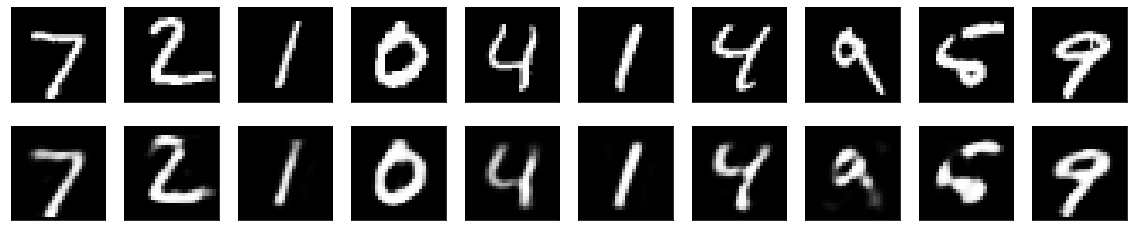

In [10]:
# Use Matplotlib
import matplotlib.pyplot as plt

n = 10 # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Top row - Original Digits
Bottom row - reconstructed digits
Lost quite a bit of detail on this basic approach.

Adding a sparsity constrain on the encoded representations

In the previous example, the representations were only constrained by the size of the hidden layer (32). In such a situation, what typically happens is that the hidden layer is learning an approximation of PCA (Principal Component Analysis). Another way to constrain the representations to be compact is to add a sparsity constraint on the activity of the hidden representations, so fewer units would "fire" at a given time. In Keras, this can be done by adding an activity_regularizer to our Dense layer.

In [12]:
from keras import regularizers

encoding_dim = 32

input_img = keras.Input(shape=(784,))

# Add a Dense layer with a L1 activity regularizer
encoded = layers.Dense(encoding_dim, activation='relu',
                      activity_regularizer=regularizers.l1(10e-5))(input_img)
decoded = layers.Dense(784, activation='sigmoid')(encoded)

autoencoder = keras.Model(input_img, decoded)

Train this model for 100 epochs (with the added regularization the model is less likely to overfit and can be trained longer). The models ends with a train loss of 0.11 and test loss of 0.10. The difference between the two is mostly due to the regularization term being added to the loss during training (worth about 0.01)

In [14]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.fit(x_train, x_train,
               epochs=100,
               batch_size=256,
               shuffle=True,
               validation_data=(x_test, x_test))

Epoch 1/100
235/235 [==============================] - 1s 5ms/step - loss: 0.2846 - val_loss: 0.1960
Epoch 2/100
235/235 [==============================] - 1s 5ms/step - loss: 0.1767 - val_loss: 0.1589
Epoch 3/100
235/235 [==============================] - 1s 5ms/step - loss: 0.1505 - val_loss: 0.1405
Epoch 4/100
235/235 [==============================] - 1s 5ms/step - loss: 0.1359 - val_loss: 0.1287
Epoch 5/100
235/235 [==============================] - 1s 5ms/step - loss: 0.1262 - val_loss: 0.1210
Epoch 6/100
235/235 [==============================] - 1s 5ms/step - loss: 0.1197 - val_loss: 0.1158
Epoch 7/100
235/235 [==============================] - 1s 5ms/step - loss: 0.1152 - val_loss: 0.1121
Epoch 8/100
235/235 [==============================] - 1s 5ms/step - loss: 0.1121 - val_loss: 0.1095
Epoch 9/100
235/235 [==============================] - 1s 6ms/step - loss: 0.1099 - val_loss: 0.1076
Epoch 10/100
235/235 [==============================] - 1s 5ms/step - loss: 0.1083 - val_lo

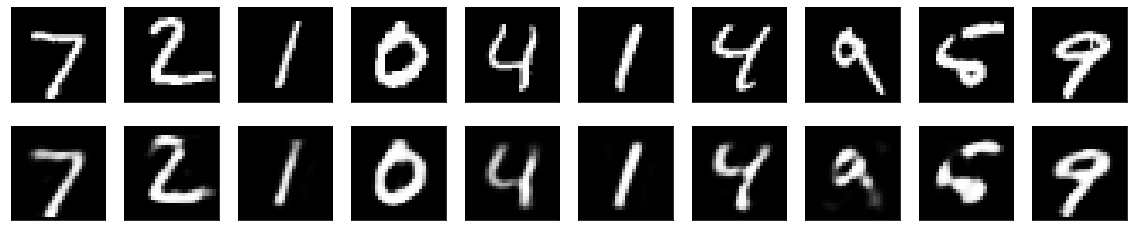

In [18]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

n = 10 # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Convolutional autoencoder

Since our input are images, it makes sense to use convolutional neural networks (convnets) as encoders and decoders. In practical settings, autoencoders applied to images are always convolutional autoencoders -- they simply perform much better.

Let's implement one. The encoder will consist in a stack of Conv2D and MaxPooling layers (max pooling being used for spatial down-sampling), while decoder will consist in a stach of Conv2D and UpSampling2D layers.

In [20]:
import keras
from keras import layers

input_img = keras.Input(shape=(28, 28, 1))

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

To train it, we will use the original MNIST digits with shape (samples, 3, 28, 28), and we will just normalize pixel values between 0 and 1.

In [21]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))


Train the model for 50 epochs. For the sake of demonstrating how to visualize the results of a model during training, we will be using the TensorFlow backend and the TensorBoard callback.

Train the model. In the callbacks list, pass an instance of the TensorBoard callback. After every epoch, this callback will write logs to /tmp/autoencoder, which can be read by our TensorBoard server.

In [23]:
from keras.callbacks import TensorBoard

autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='tmp/autoencoder')])

Epoch 1/50
  1/469 [..............................] - ETA: 0s - loss: 0.6917WARNING:tensorflow:From /opt/anaconda3/envs/U4-S1-NLP/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
469/469 [==============================] - 60s 127ms/step - loss: 0.2086 - val_loss: 0.1414
Epoch 2/50
469/469 [==============================] - 57s 121ms/step - loss: 0.1324 - val_loss: 0.1245
Epoch 3/50
469/469 [==============================] - 55s 118ms/step - loss: 0.1216 - val_loss: 0.1177
Epoch 4/50
469/469 [==============================] - 56s 119ms/step - loss: 0.1158 - val_loss: 0.1125
Epoch 5/50
469/469 [==============================] - 57s 122ms/step - loss: 0.1118 - val_loss: 0.1088
Epoch 6/50
469/469 [==============================] - 58s 124ms/step - loss: 0.1089 - val_loss: 0.1063
Epoch 7/50
469/469 [

The model converges to a loss of 0.094, significantly better than our previous models (this is in large part due to the higher entropic capacity of the encoded representation, 128 dimensions vs 32 previously). Take a look at the reconstructed digits:

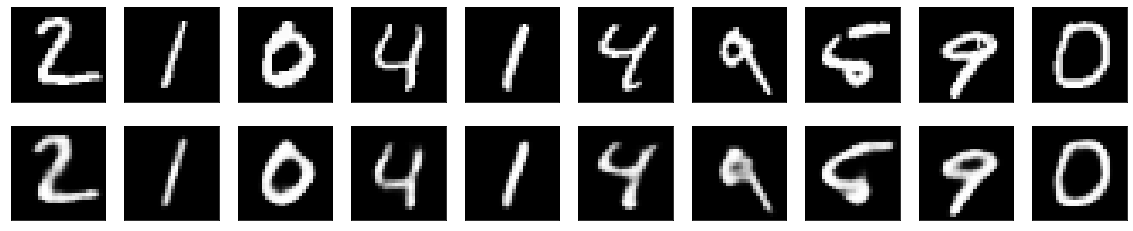

In [24]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Also have a look at the 128-dimensional encoded representations. These representations are 8x4x4, so we reshape them to 4x32 in order to be able to display them as grayscale images.

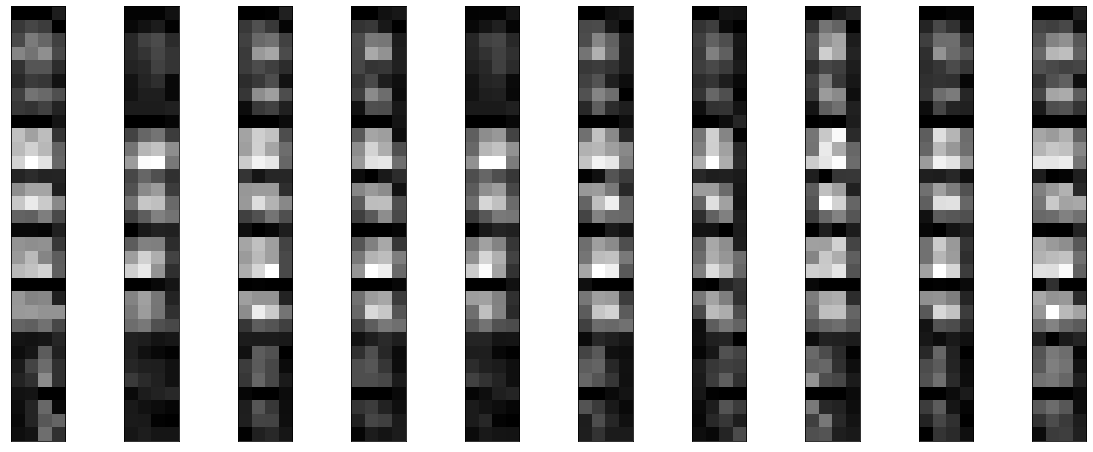

In [25]:
encoder = keras.Model(input_img, encoded)
encoded_imgs = encoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 8))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(encoded_imgs[i].reshape((4, 4 * 8)).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Application to image denoising

Put the convolutional autoencoder to work on an image denoising problem. Train the autoencoder to map noisy digits images to clean digits images.

Here's how to generate synthetic noisy digits: just apply a gaussian noise matrix and clip the images between 0 and 1.

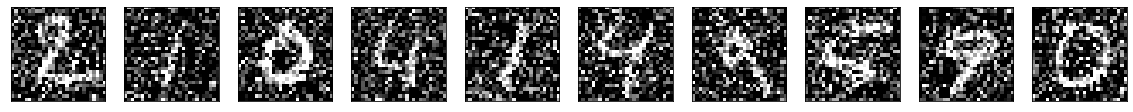

In [3]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

# here's what the noisy digits look like:
import matplotlib.pyplot as plt

n = 10
plt.figure(figsize=(20, 2))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

If you squint you can still recognize them, but barely. Can our autoencoder learn to recover the original digits? Let's find out.

Compared to the previous convolutional autoencoder, in order to improve the quality of the reconstructed, we'll use a slightly different model with more filters per layer:

In [7]:
import keras
from keras import layers
from keras.callbacks import TensorBoard

input_img = keras.Input(shape=(28, 28, 1))

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# At this point the representation is (7, 7, 32)

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.fit(x_train_noisy, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)])

Epoch 1/100
  1/469 [..............................] - ETA: 0s - loss: 0.6600WARNING:tensorflow:From /opt/anaconda3/envs/U4-S1-NLP/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
469/469 [==============================] - 143s 305ms/step - loss: 0.1560 - val_loss: 0.1155
Epoch 2/100
469/469 [==============================] - 146s 311ms/step - loss: 0.1122 - val_loss: 0.1076
Epoch 3/100
469/469 [==============================] - 125s 267ms/step - loss: 0.1069 - val_loss: 0.1043
Epoch 4/100
469/469 [==============================] - 117s 249ms/step - loss: 0.1043 - val_loss: 0.1040
Epoch 5/100
469/469 [==============================] - 115s 246ms/step - loss: 0.1025 - val_loss: 0.1009
Epoch 6/100
469/469 [==============================] - 117s 250ms/step - loss: 0.1012 - val_loss: 0.1001
Epoch 7/